In [3]:
%pip install numpy pandas matplotlib seaborn tensorflow keras opencv-python tqdm scikit-learn

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [4]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random



## Load and Parse Annotations

In [5]:
# Define dataset path
DATA_DIR = "data/vehicle_number_plate_detection"
IMAGE_DIR = os.path.join(DATA_DIR, "images")
LABEL_DIR = os.path.join(DATA_DIR, "labels")
IMAGE_EXT = ".jpg"


In [6]:
# Function to parse YOLO annotation files
def parse_yolo_annotation(txt_file):
    with open(txt_file, "r") as file:
        annotations = []
        for line in file:
            parts = line.strip().split()
            label = int(parts[0])  # class label
            
            # Normalized center coordinates and dimensions
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Get the image filename (assuming image and annotation share the same basename)
            filename = txt_file.replace(".txt", IMAGE_EXT)

            # Store the normalized values
            annotations.append((filename, x_center, y_center, width, height, label))

    return annotations


In [8]:
# Load all annotations
annotation_files = glob.glob(os.path.join(LABEL_DIR, "*.txt"))
data = []

for txt_file in tqdm(annotation_files, desc="Parsing Annotations"):
    data.extend(parse_yolo_annotation(txt_file))

# Convert to DataFrame
columns = ["filename", "x_center", "y_center", "width", "height", "label"]
df = pd.DataFrame(data, columns=columns)
df.head()


Parsing Annotations: 100%|██████████| 8078/8078 [00:50<00:00, 160.31it/s]  


,filename,x_center,y_center,width,height,label
0,data/vehicle_number_plate_detection\labels\202...,0.508677,0.415776,0.271814,0.069569,0
1,data/vehicle_number_plate_detection\labels\202...,0.818775,0.671229,0.187053,0.111533,0
2,data/vehicle_number_plate_detection\labels\202...,0.940699,0.428320,0.060487,0.071811,0
3,data/vehicle_number_plate_detection\labels\202...,0.878327,0.564796,0.207424,0.127523,0
4,data/vehicle_number_plate_detection\labels\202...,0.854865,0.488487,0.236695,0.151168,0


## Data Preprocessing

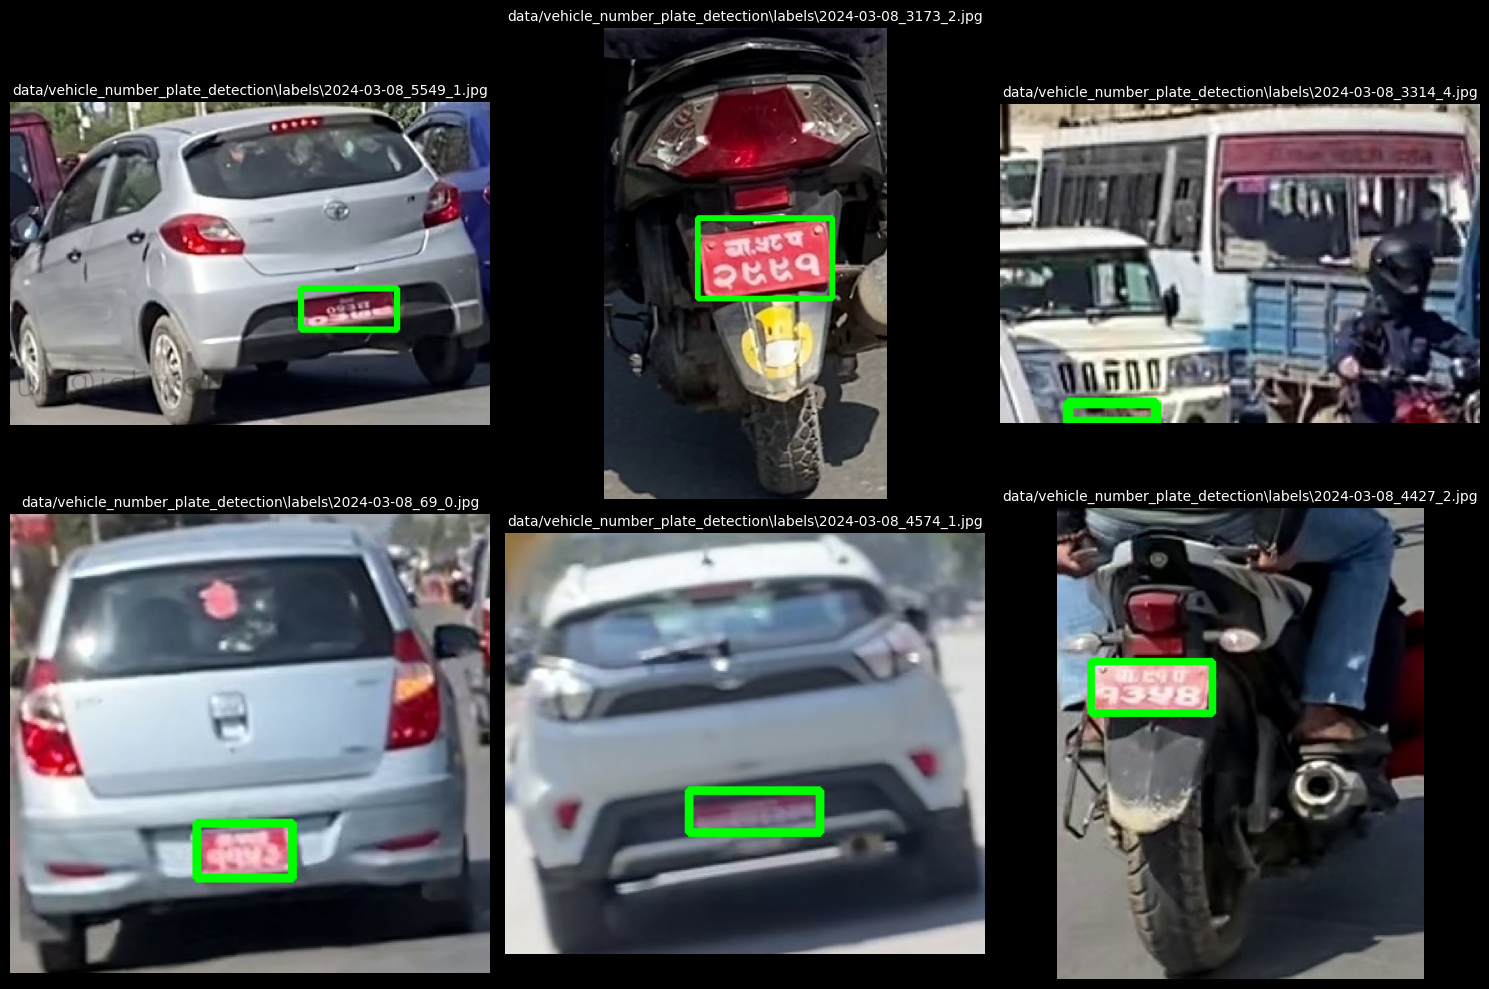

In [13]:

plt.style.use("dark_background")  # Enable dark mode

def show_sample_images(df, num_samples=6):
    sample_files = df["filename"].unique()
    num_samples = min(num_samples, len(sample_files))  # Adjust if fewer images exist
    selected_files = random.sample(list(sample_files), num_samples)  # Random selection
    
    num_rows, num_cols = 2, 3  # 2 rows, 3 columns
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten for easy iteration

    for i, file in enumerate(selected_files):
        img_path = file.replace("labels", "images")  # Update path if necessary
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        sample_data = df[df["filename"] == file]
        for _, row in sample_data.iterrows():
            # Convert from YOLO format to (xmin, ymin, xmax, ymax)
            x_center, y_center, width, height = row["x_center"], row["y_center"], row["width"], row["height"]
            xmin = int((x_center - width / 2) * img.shape[1])
            ymin = int((y_center - height / 2) * img.shape[0])
            xmax = int((x_center + width / 2) * img.shape[1])
            ymax = int((y_center + height / 2) * img.shape[0])

            # Draw bounding box
            cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 4)

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(file, fontsize=10, color="white")

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig("sample_images.png", dpi=300, bbox_inches="tight")
    plt.show()

# Call the function
show_sample_images(df)

In [ ]:
# Function to load and preprocess images
IMG_SIZE = (128, 128)

def load_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.resize(img, IMG_SIZE)
    img = img.astype("float32") / 255.0  # Normalize
    return img

# Load dataset
X = []
y = []

for _, row in tqdm(df.iterrows(), total=len(df), desc="Processing Images"):
    img_path = row["filename"].replace("labels", "images")
    X.append(load_image(img_path))

    # Normalize bounding box coordinates
    norm_bbox = [
        row["x_center"],
        row["y_center"],
        row["width"],
        row["height"],
    ]
    y.append(norm_bbox)

X = np.array(X)
y = np.array(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train set: {len(X_train)}, Test set: {len(X_test)}")


Processing Images: 100%|██████████| 8720/8720 [00:41<00:00, 209.51it/s]


Train set: 6976, Test set: 1744


## Building the CNN Model

### Define the IoU Loss

In [ ]:
def iou_loss(y_true, y_pred):
    # Cast y_true to float32 to match the type of y_pred
    y_true = tf.cast(y_true, tf.float32)
    
    # Extract ground truth and predicted coordinates in x_center, y_center, width, height form
    x_center_true, y_center_true, width_true, height_true = tf.split(y_true, 4, axis=-1)
    x_center_pred, y_center_pred, width_pred, height_pred = tf.split(y_pred, 4, axis=-1)
    
    # Convert x_center, y_center, width, height to xmin, ymin, xmax, ymax
    xmin_true = x_center_true - width_true / 2
    ymin_true = y_center_true - height_true / 2
    xmax_true = x_center_true + width_true / 2
    ymax_true = y_center_true + height_true / 2

    xmin_pred = x_center_pred - width_pred / 2
    ymin_pred = y_center_pred - height_pred / 2
    xmax_pred = x_center_pred + width_pred / 2
    ymax_pred = y_center_pred + height_pred / 2
    
    # Calculate intersection area
    inter_x1 = tf.maximum(xmin_true, xmin_pred)
    inter_y1 = tf.maximum(ymin_true, ymin_pred)
    inter_x2 = tf.minimum(xmax_true, xmax_pred)
    inter_y2 = tf.minimum(ymax_true, ymax_pred)
    
    inter_area = tf.maximum(inter_x2 - inter_x1, 0) * tf.maximum(inter_y2 - inter_y1, 0)
    
    # Calculate union area
    true_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    pred_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    
    union_area = true_area + pred_area - inter_area
    
    # IoU is the intersection area divided by union area
    iou = inter_area / (union_area + tf.keras.backend.epsilon())
    
    # Return 1 - IoU as loss (lower IoU means higher loss)
    return 1 - iou


In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(4, activation="sigmoid")  # Bounding box output (xmin, ymin, xmax, ymax)
])

model.compile(optimizer="adam", loss="mse", metrics=["mae", iou_loss])
model.summary()

c:\Users\Brian\OneDrive - University of Witwatersrand\Desktop\off_the_grid\projects\ebook_object_detection\.venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,060 (24.86 MB)

 Trainable params: 6,517,060 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

## Training the Model

In [ ]:
EPOCHS = 90
BATCH_SIZE = 32

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Fit the datagen on training data
datagen.fit(X_train)

# Use data augmentation during training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    verbose=1
)



Epoch 1/90
218/218 ━━━━━━━━━━━━━━━━━━━━ 51s 230ms/step - iou_loss: 0.8826 - loss: 0.0166 - mae: 0.0861 - val_iou_loss: 0.8381 - val_loss: 0.0155 - val_mae: 0.0760
Epoch 2/90
218/218 ━━━━━━━━━━━━━━━━━━━━ 53s 244ms/step - iou_loss: 0.8802 - loss: 0.0166 - mae: 0.0859 - val_iou_loss: 0.8440 - val_loss: 0.0147 - val_mae: 0.0763
Epoch 3/90
218/218 ━━━━━━━━━━━━━━━━━━━━ 56s 257ms/step - iou_loss: 0.8743 - loss: 0.0159 - mae: 0.0839 - val_iou_loss: 0.8514 - val_loss: 0.0163 - val_mae: 0.0827
Epoch 4/90
218/218 ━━━━━━━━━━━━━━━━━━━━ 54s 249ms/step - iou_loss: 0.8753 - loss: 0.0166 - mae: 0.0856 - val_iou_loss: 0.8168 - val_loss: 0.0142 - val_mae: 0.0728
Epoch 5/90
218/218 ━━━━━━━━━━━━━━━━━━━━ 55s 253ms/step - iou_loss: 0.8720 - loss: 0.0159 - mae: 0.0833 - val_iou_loss: 0.8546 - val_loss: 0.0146 - val_mae: 0.0767
Epoch 6/90
218/218 ━━━━━━━━━━━━━━━━━━━━ 55s 250ms/step - iou_loss: 0.8677 - loss: 0.0161 - mae: 0.0836 - val_iou_loss: 0.8508 - val_loss: 0.0149 - val_mae: 0.0763
Epoch 7/90
218/218 ━━━

### Save the Model

In [ ]:
model.save("plate_detection_model.h5")  # Saves in HDF5 format

## Evaluating the Model

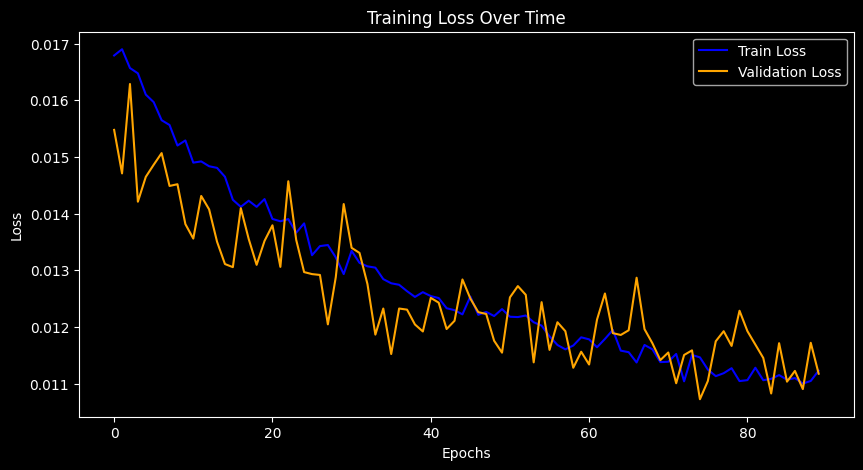

In [ ]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history["loss"], label="Train Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.show()


## Visualize Predictions

In [10]:
def visualize_predictions(model, X_test, y_test, num_samples=6):
    # Randomly select indices for images to display
    random_indices = random.sample(range(len(X_test)), num_samples)
    
    # Predict on the selected random samples
    preds = model.predict(X_test[random_indices])

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # 2x3 grid

    for i, idx in enumerate(random_indices):
        img = (X_test[idx] * 255).astype("uint8")
        
        # Convert true bbox from center (x_center, y_center, width, height) to (xmin, ymin, xmax, ymax)
        true_x_center, true_y_center, true_width, true_height = y_test[idx]
        true_xmin = int((true_x_center - true_width / 2) * IMG_SIZE[0])
        true_ymin = int((true_y_center - true_height / 2) * IMG_SIZE[1])
        true_xmax = int((true_x_center + true_width / 2) * IMG_SIZE[0])
        true_ymax = int((true_y_center + true_height / 2) * IMG_SIZE[1])

        # Convert predicted bbox from center (x_center, y_center, width, height) to (xmin, ymin, xmax, ymax)
        pred_x_center, pred_y_center, pred_width, pred_height = preds[i]
        pred_xmin = int((pred_x_center - pred_width / 2) * IMG_SIZE[0])
        pred_ymin = int((pred_y_center - pred_height / 2) * IMG_SIZE[1])
        pred_xmax = int((pred_x_center + pred_width / 2) * IMG_SIZE[0])
        pred_ymax = int((pred_y_center + pred_height / 2) * IMG_SIZE[1])

        # Draw bounding boxes (green for true, red for predicted)
        cv2.rectangle(img, (true_xmin, true_ymin), (true_xmax, true_ymax), (0, 255, 0), 2)  # True bbox in green
        cv2.rectangle(img, (pred_xmin, pred_ymin), (pred_xmax, pred_ymax), (255, 0, 0), 2)  # Pred bbox in red

        # Place image in correct subplot
        ax = axes[i // 3, i % 3]
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"Image {idx+1}")

    plt.tight_layout()
    plt.show()

# Call the function to visualize random predictions
visualize_predictions(model, X_test, y_test)

NameError: name 'model' is not defined